 a) If you were to only consider the provider's effectiveness with regard to this particular treatment, would you recommend reaching out to any of these doctors in particular? If so, which ones, and why?
# calculate an avg outcome of patients treated by all doctors, then compare each doctor with the avg outcome to select the one with the lowest outcome (less follow-ups)
 b) What other data would be helpful in understanding which doctors to reach out to? What other data would be help you evaluate the overall clinical effectiveness of the doctor? How would you use this data?
# cal avg outcome of patients grouped by risk assessment, sex, age, then compare each doctor under these afforementioned conditions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


import xgboost as xgb
import warnings
import numpy as np

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


* remove completely empty rows

##You should add parse_dates=True, or parse_dates=['column name'] when reading, thats usually enough to magically parse it. But there are always weird formats which need to be defined manually. In such a case you can also add a date parser function, which is the most flexible way possible.

Suppose you have a column 'datetime' with your string, then:

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

df = pd.read_csv(infile, parse_dates=['datetime'], date_parser=dateparse)
This way you can even combine multiple columns into a single datetime column, this merges a 'date' and a 'time' column into a single 'datetime' column:

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

df = pd.read_csv(infile, parse_dates={'datetime': ['date', 'time']}, date_parser=dateparse)

In [13]:
clover = pd.read_csv("Product Data.csv", parse_dates=['treatment_date'], skip_blank_lines=True).dropna(how='all')

skip_blank_lines
bool, default True
If True, skip over blank lines rather than interpreting as NaN values. ##True or False, don't see any difference??????

In [14]:
clover.shape

(4247, 9)

In [15]:
clover.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4247 entries, 1 to 8493
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   event_id                 4247 non-null   float64       
 1   servicing_provider_id    4247 non-null   float64       
 2   servicing_provider_name  4247 non-null   object        
 3   treatment_date           4247 non-null   datetime64[ns]
 4   member_id                4247 non-null   float64       
 5   member_age               4247 non-null   float64       
 6   member_sex               4247 non-null   float64       
 7   health_risk_assesment    4247 non-null   float64       
 8   outcome                  2413 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 331.8+ KB


In [16]:
clover.head()

,event_id,servicing_provider_id,servicing_provider_name,treatment_date,member_id,member_age,member_sex,health_risk_assesment,outcome
1,662.0,9.0,Evil,2015-02-02,1003.0,71.0,0.0,7.0,failure
3,624.0,74.0,Banting,2015-03-17,1005.0,64.0,0.0,3.0,failure
5,558.0,88.0,Broca,2015-12-13,1008.0,65.0,1.0,2.0,NaN
7,3368.0,31.0,Martin,2015-03-03,1013.0,72.0,0.0,4.0,failure
9,673.0,59.0,Venture,2015-06-02,1015.0,73.0,1.0,7.0,NaN


* 'outcome' is the label. There are 2413 outcome as 'failure', the rest is NaN

In [17]:
clover['outcome'].unique()

array(['failure', nan], dtype=object)

In [18]:
clover['outcome'].value_counts()

failure    2413
Name: outcome, dtype: int64

* Set'failure' as  1, NaN as 0

In [19]:
clover['outcome'] = clover['outcome'].fillna(0)
clover['outcome'] = clover['outcome'].replace('failure', 1)

In [20]:
clover['outcome'].unique()

array([1, 0], dtype=int64)

* There is unique name and ID for the 96 doctors, therefore the 'servicing_provider_id' and 'servicing_provider_name'can be used interchangeably

In [21]:
clover['servicing_provider_id'].nunique(), clover['servicing_provider_name'].nunique()

(96, 96)

### Perform EDA on the data

* The data is relatively balanced, with failure (having the disease) % of ~57% and and success (not having the disease)% as ~43%

In [23]:
clover['outcome'].value_counts(normalize=True) 

1    0.568166
0    0.431834
Name: outcome, dtype: float64

##What is the purpose of pairplot????

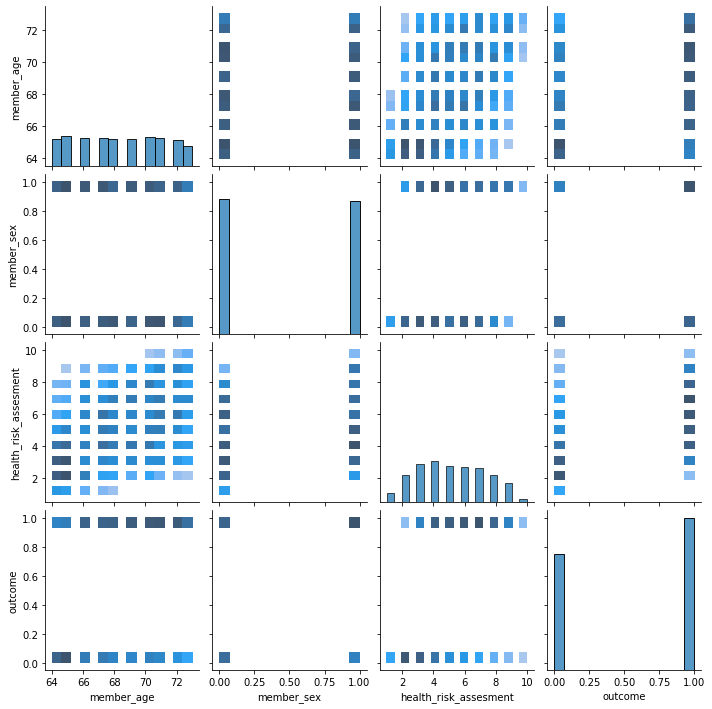

In [11]:
sns.pairplot(clover[['member_age', 'member_sex', 'health_risk_assesment', 'outcome']], 
             kind='hist')
plt.show();

* Check the time range of the data, entire year of 2015
* The outcome is not dependent on treatment date 
* The treatment date does not provide too much info in the dataset, therefore it will not be included in the modelling

In [25]:
clover['treatment_date'].min(), clover['treatment_date'].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-31 00:00:00'))

##how could you draw the conclusion that outcome is independent of treatment date??

In [26]:
date_eff = clover.groupby(['treatment_date'])['outcome'].mean().reset_index()
date_eff

,treatment_date,outcome
0,2015-01-01,0.500000
1,2015-01-02,0.583333
2,2015-01-03,0.461538
3,2015-01-04,0.466667
4,2015-01-05,0.700000
...,...,...
360,2015-12-27,0.500000
361,2015-12-28,0.666667
362,2015-12-29,0.571429
363,2015-12-30,0.375000


In [89]:
date_eff_std = clover.groupby(['treatment_date'])['outcome'].std().reset_index()
date_eff_std

,treatment_date,outcome
0,2015-01-01,0.522233
1,2015-01-02,0.514929
2,2015-01-03,0.518875
3,2015-01-04,0.516398
4,2015-01-05,0.483046
...,...,...
360,2015-12-27,0.534522
361,2015-12-28,0.487950
362,2015-12-29,0.513553
363,2015-12-30,0.517549


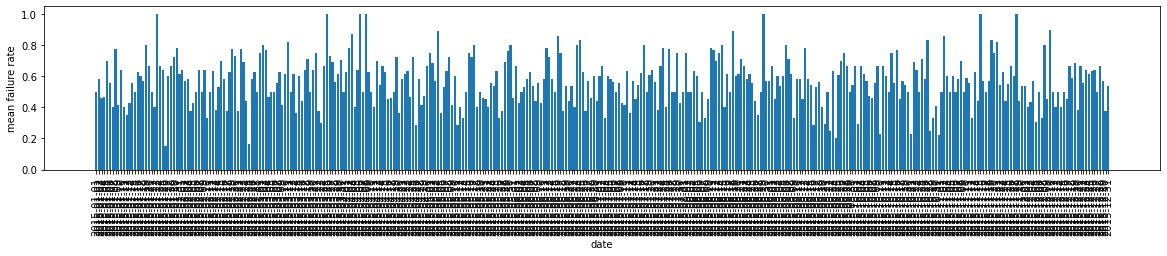

In [106]:
fig, ax=plt.subplots(figsize=(20, 3))
ax.bar(x=date_eff['treatment_date'], height=date_eff['outcome'])

plt.xticks(date_eff['treatment_date'], rotation=90)
plt.xlabel('date')
plt.ylabel('mean failure rate')
plt.show()

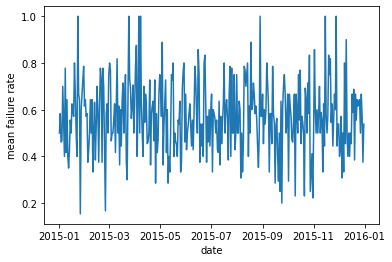

In [105]:
plt.plot(date_eff['treatment_date'], date_eff['outcome'])
plt.xlabel('date')
plt.ylabel('mean failure rate')
plt.show()

* For different age, sex and health risk factor, the failure/success ratio is different
* When patient is older the 66, the disease is more likely to be present

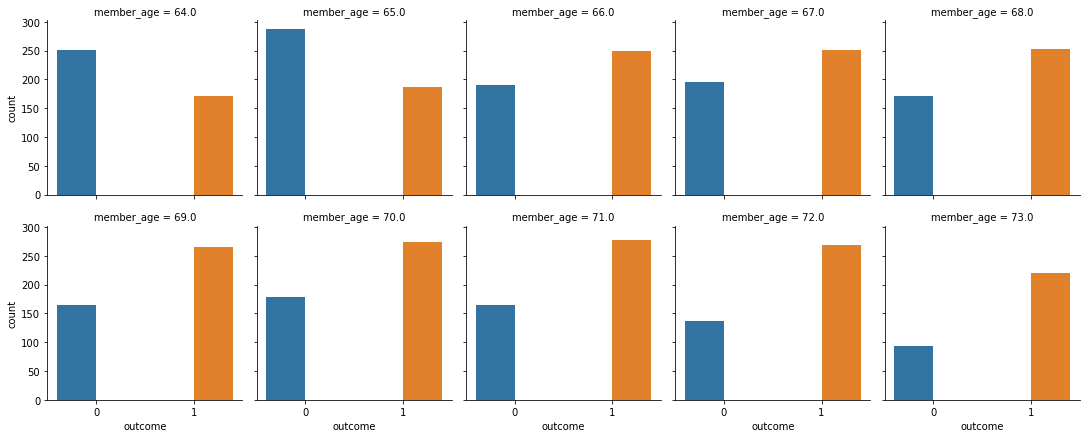

In [36]:
g = sns.catplot(x="outcome", col="member_age", col_wrap=5,
                data=clover,
                kind="count", height=3.0, hue='outcome')
plt.show();


* For female (sex = 0) patients, the ratio of having disease vs not having disease is almost 0.5
* For male (sex = 1) patients, the ratio of having disease is higher than not having disease

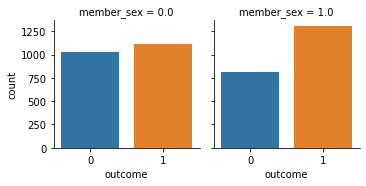

In [38]:
g = sns.catplot(x="outcome", col="member_sex", data=clover,
                kind="count", height= 2.5)


In [44]:
sex_outcome=clover.groupby(['member_sex'])['outcome'].mean()
sex_outcome

member_sex
0.0    0.520112
1.0    0.616880
Name: outcome, dtype: float64

* For low health_risk patients (risk 1 and 2), they rarely have the disease
* The higher the risk_assessment number, the more likely the patient will have the disease

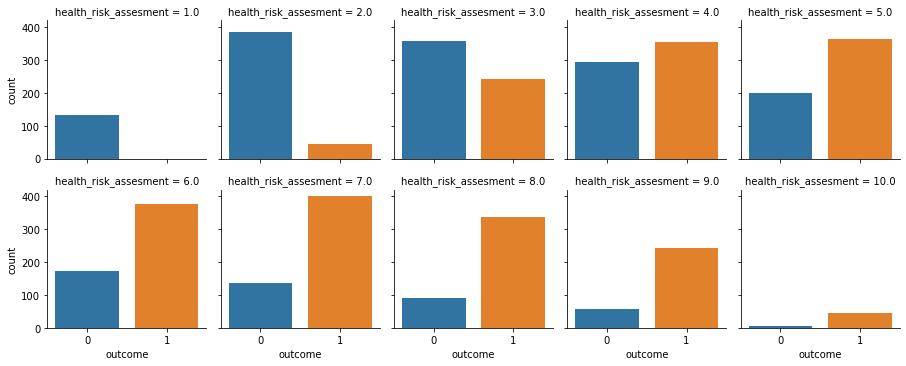

In [45]:
g = sns.catplot(x="outcome", col="health_risk_assesment", col_wrap=5,
                data=clover,
                kind="count", height=2.5)

* There are 96 distinct doctors, they have treated different numbers of patients
* There are 4247 patients, and maximum number of doctors one patient has is 1.

In [46]:
print('There are {} doctors.'.format(clover.servicing_provider_name.nunique()))

There are 96 doctors.


In [47]:
print('There are {} patients, and maximum number of doctors one patient has is {}.'.format(
    clover.member_id.nunique(),
    clover.groupby(['member_id'])['servicing_provider_name'].count().max()))

There are 4247 patients, and maximum number of doctors one patient has is 1.


* The average patient age treated by different doctors is similar

#plt.subplots() is a function that returns a tuple containing a figure and axes object(s). Thus when using fig, ax = plt.subplots() you unpack this tuple into the variables fig and ax. Having fig is useful if you want to change figure-level attributes or save the figure as an image file later (e.g. with fig.savefig('yourfilename.png')). You certainly don't have to use the returned figure object but many people do use it later so it's common to see. Also, all axes objects (the objects that have plotting methods), have a parent figure object anyway

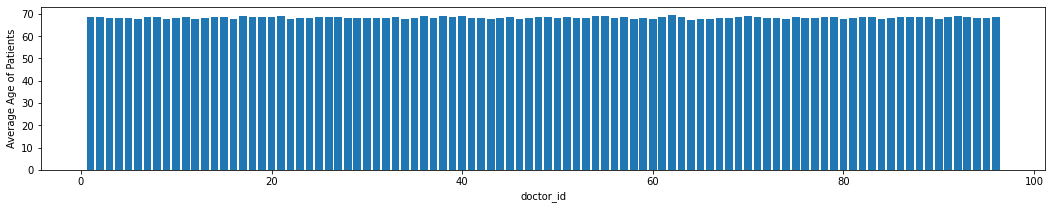

In [48]:
patients_age=clover.groupby(
    ['servicing_provider_id'])['member_age'].mean()

fig, ax=plt.subplots(figsize=(18, 3))
_=ax.bar(x=patients_age.index, height=patients_age.values)
plt.ylabel('Average Age of Patients')
plt.xlabel('doctor_id')
plt.show();

In [50]:
patients_age

servicing_provider_id
1.0     68.717391
2.0     68.714286
3.0     68.069767
4.0     68.315789
5.0     67.976744
          ...    
92.0    69.243902
93.0    68.659091
94.0    68.290909
95.0    68.025000
96.0    68.450980
Name: member_age, Length: 96, dtype: float64

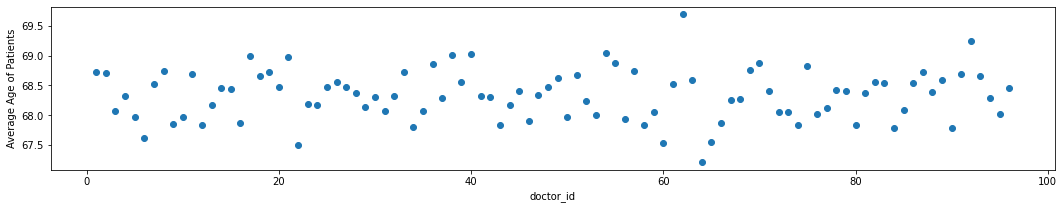

In [59]:
fig, ax=plt.subplots(figsize=(18, 3))
ax.scatter(x=patients_age.index, y=patients_age.values)
plt.ylabel('Average Age of Patients')
plt.xlabel('doctor_id')
plt.show()

* The average patient health risk assesment score treated by different doctors is similar

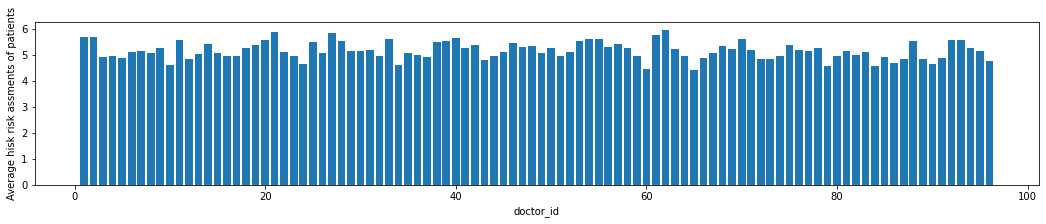

In [60]:
patients_risk=clover.groupby(
    ['servicing_provider_id'])['health_risk_assesment'].mean()

fig, ax=plt.subplots(figsize=(18, 3))
_=ax.bar(x=patients_age.index, height=patients_risk.values)
plt.ylabel('Average hisk risk assments of patients')
plt.xlabel('doctor_id')
plt.show();

* The ratio of male vs. female patients is different for each doctor

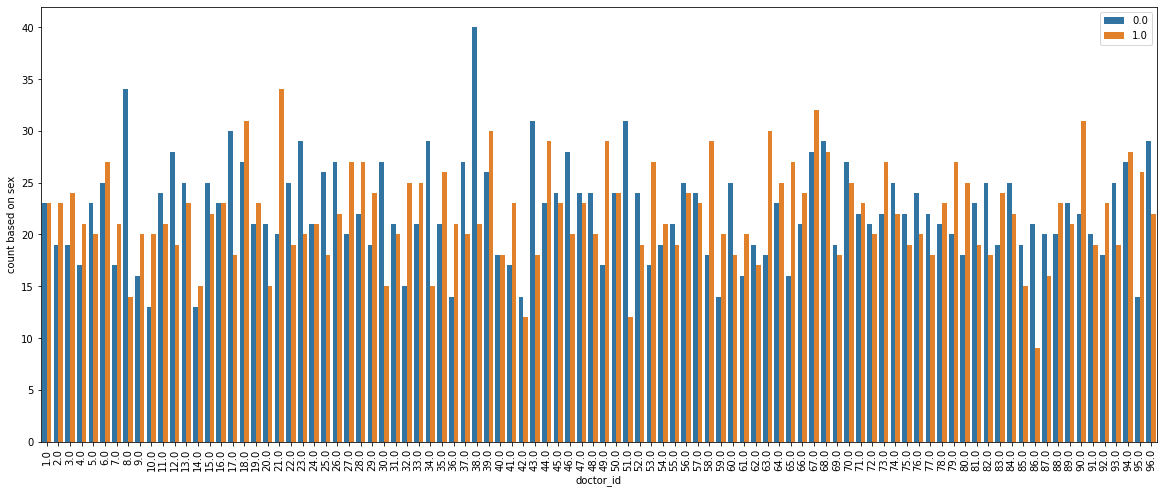

In [61]:
patients_sex=clover.groupby(
    ['servicing_provider_id', 'member_sex'])['member_id'].count()

plt.figure(figsize = (20,8))

sns.barplot(x=patients_sex.index.get_level_values(0), 
            y=patients_sex.values, hue =patients_sex.index.get_level_values(1))

plt.xticks(rotation=90)
plt.ylabel('count based on sex')
plt.xlabel('doctor_id')
plt.legend()
plt.show();

In [82]:
male_means = clover[clover['member_sex']==1].groupby(
    ['servicing_provider_id'])['member_id'].count()
female_means = clover[clover['member_sex']==0].groupby(
    ['servicing_provider_id'])['member_id'].count()


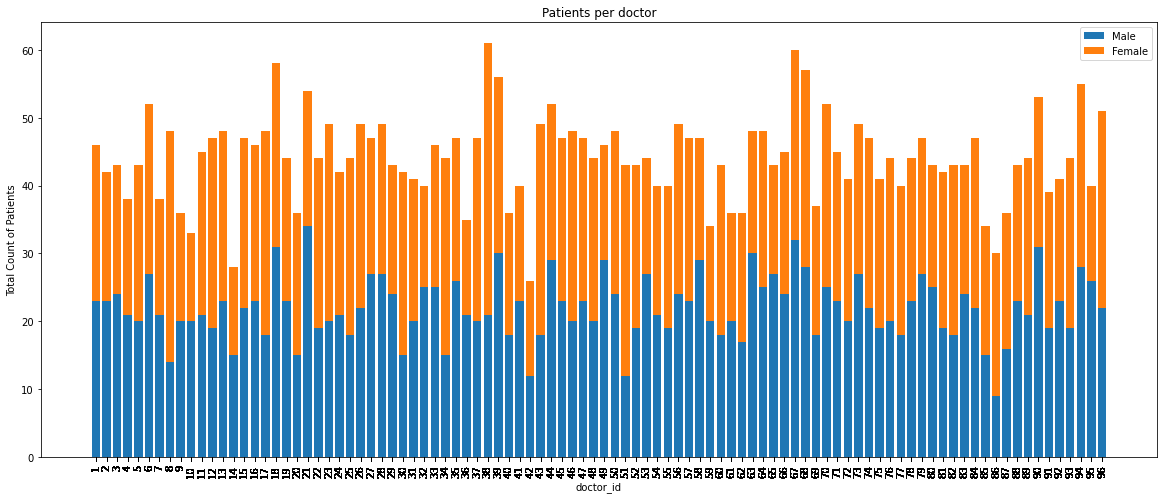

In [88]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.bar(male_means.index, male_means,label='Male')
ax.bar(female_means.index, female_means, bottom=male_means,
       label='Female')
ax.set_xticks(clover['servicing_provider_id'])
plt.xticks(rotation=90)
ax.set_ylabel('Total Count of Patients')
ax.set_xlabel('doctor_id')
ax.set_title('Patients per doctor')
ax.legend()

plt.show()

* Doctor with ID 42 has treated the least number of patients while doctor with ID 38 (Dr. Toboggan) has treated the most number of patients followed by ID 67 (Dr. Doom)


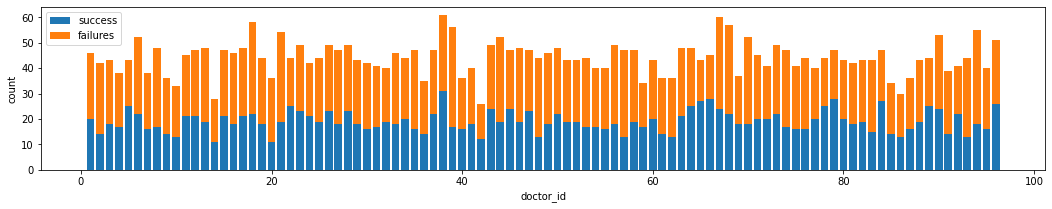

In [62]:
patients=clover.groupby(
    ['servicing_provider_id'])['member_id'].count()
success=clover.loc[[(ele == 0) for ele in clover.outcome]].groupby(
    ['servicing_provider_id'])['member_id'].count()
success = success.rename('success')
failures=clover.loc[[(ele == 1) for ele in clover.outcome]].groupby(
    ['servicing_provider_id'])['member_id'].count()
failures = failures.rename('failure')
fig, ax=plt.subplots(1, 1, figsize=(18, 3))
_=ax.bar(x=patients.index, height=success.values, label='success')
_=ax.bar(x=patients.index, height=failures.values, bottom = success.values, label='failures')
plt.ylabel('count')
plt.xlabel('doctor_id')
plt.legend()
plt.show()

In [63]:
patients.head()

servicing_provider_id
1.0    46
2.0    42
3.0    43
4.0    38
5.0    43
Name: member_id, dtype: int64

* The treatment effectiveness (success treatment/failures ratio is different). 
* Doctor ID 65 (Dr. Demento) has the highest success rate
* Doctor ID 57 (Dr. Spaceman) has the lowest sccess rate
* Since the doctors are treating patients with different conditions, this treatment effectiveness is not enough to evaluate the doctor's performance

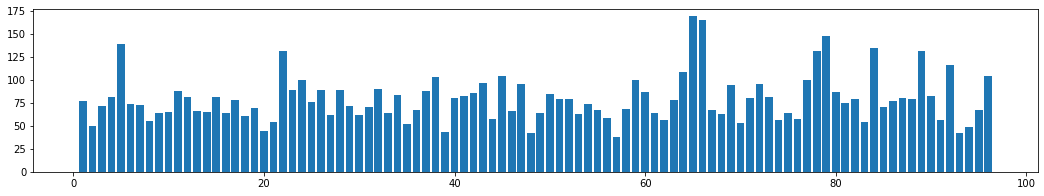

In [24]:
fig, ax=plt.subplots(figsize=(18, 3))

_=ax.bar(x=patients.index, height=success.values/failures.values * 100)


### Modelling  Assumption and Strategy

Regarding this chronic condition there should be an average failure rate solely based on patients' sex, age, and health risk assessment. 

Considering this situation, I am going to make several assumptions: 1) a supervised learning model can summerize an average relationship between patients' sex, age, and health conditions and the final result: failure or not; 2) when I look at each patient if the model prediction is different than the real result, I believe that is because of the doctor's treatment (could be good or bad); 3) the effectiveness of a doctor's treatment will be evaluated based on the model predicted result vs outcome from doctor's treatment (e.g. if prediction is 0 (meaning the patient does not have the disease) while outcome is 1 (meaning having disease from doctor's diagnosis) then '-1' points for the doctor

In [25]:
data = clover.set_index('member_id')
data = data.drop(['event_id', 'servicing_provider_name','treatment_date','servicing_provider_id'], axis = 1)
data.head()

,member_age,member_sex,health_risk_assesment,outcome
member_id,,,,
1003.0,71.0,0.0,7.0,1
1005.0,64.0,0.0,3.0,1
1008.0,65.0,1.0,2.0,0
1013.0,72.0,0.0,4.0,1
1015.0,73.0,1.0,7.0,0


In [26]:
X = data.drop(columns = ['outcome']).copy()
y = data['outcome']

# Split the data in training and testing dataset. 
# Since this is a small dataset, cross validation will be applied when trainning the model
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, shuffle = True)


In [27]:
cat_attribs = ['member_sex', 'health_risk_assesment']
num_attribs = ['member_age']
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_attribs),
    ('cat', OrdinalEncoder(handle_unknown='ignore'), cat_attribs)])
X_train_prepared = preprocessor.fit_transform(X_train)
X_train_prepared.shape

(3397, 3)

In [28]:
X_test_prepared = preprocessor.transform(X_test)

# Compare two classification models (XGBoost and RF)
### Hyperparameter tuning on XGBoost classification modelling with cross validation

In [29]:

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
colsample_bytree = [0.3, 0.5, 0.7]
learning_rate = [0.01, 0.05, 0.1]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'colsample_bytree': colsample_bytree,
               'max_depth': max_depth,
               'learning_rate': learning_rate}

xgb = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator = xgb, 
                               param_distributions = random_grid,
                                scoring = 'roc_auc',
                               n_iter = 20, cv = 4, verbose=2, 
                               random_state=42, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train_prepared, y_train)


Fitting 4 folds for each of 20 candidates, totalling 80 fits
[22:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [30]:
xgb_best_random = xgb_random.best_estimator_
xgb_best_random

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=70,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1800, n_jobs=4, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [61]:
xgb_best_score = xgb_random.best_score_
xgb_best_score

0.7405518971901967

In [62]:
def plot_learning_curves(model, X,y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(accuracy_score(y_train[:m], y_train_predict))
        val_errors.append(accuracy_score(y_val, y_val_predict))
    plt.plot(train_errors, 'r-+', linewidth = 2, label = 'train')
    plt.plot(val_errors, 'b-', linewidth =3, label = 'val')

In [73]:
xgb_clf = XGBClassifier(colsample_bytree=0.5,learning_rate=0.01,max_depth=70, 
                               n_estimators=1800,random_state=42)
plot_learning_curves(xgb_clf, X_train_prepared, y_train.values)

[15:36:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:36:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:36:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:36:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:37:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:37:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:38:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:38:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:39:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:39:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:40:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:40:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:41:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:42:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:43:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:44:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:45:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:47:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:48:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:48:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[15:49:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

KeyboardInterrupt: 

In [32]:
xgb_clf = XGBClassifier(colsample_bytree=0.5,learning_rate=0.01,max_depth=70, 
                               n_estimators=1800,random_state=42)
 

xgb_clf.fit(X_train_prepared, y_train)
 
pred_prob_xgb = xgb_clf.predict_proba(X_test_prepared)

[22:44:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [33]:
xgb_auc = roc_auc_score(y_test, pred_prob_xgb[:,1])
xgb_auc

0.7592128203967031

### Hyperparameter tubing of RF model with cross validation

In [34]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}

In [35]:
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 20, cv = 4, verbose=2, 
                               scoring = 'roc_auc',
                               random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_prepared, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [36]:
rf_best_random = rf_random.best_estimator_
rf_best_random

RandomForestClassifier(max_depth=100, min_samples_split=10, n_estimators=600)

* The best model score of XGBoost is slightly better than RF. XGBoost will be used as the model to make predictions

In [37]:
rf_best_score = rf_random.best_score_
rf_best_score

0.7250057142200105

In [38]:
rf_clf = RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=1000, random_state = 42) 
rf_clf.fit(X_train_prepared, y_train)
 
pred_prob_rf = rf_clf.predict_proba(X_test_prepared)

* the auc score for test data is slightly better than validation data, indicating model is not overfitting

In [39]:
rf_auc = roc_auc_score(y_test, pred_prob_rf[:,1])
rf_auc

0.7145950321528848

* Plot the ROC curve for RF and XGBoost model
* XGBoost has slightly better performance than RF, which is consistent with best score

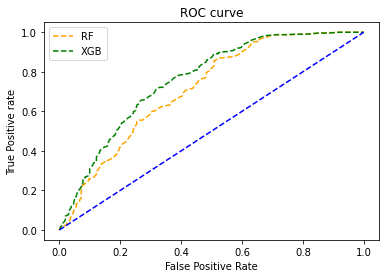

In [40]:
pred_prob_rf = rf_clf.predict_proba(X_test_prepared)
pred_prob_xgb = xgb_clf.predict_proba(X_test_prepared)


# roc curve for models
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, pred_prob_rf[:,1], pos_label=1)
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)


# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr_rf, tpr_rf, linestyle='--',color='orange', label='RF')
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='green', label='XGB')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="upper left")
plt.show();

### Apply the optimized XGBoost model on entire clover data set to rank doctors

In [41]:
clover_test = clover[['member_id', 'servicing_provider_name', 
                      'member_age', 'member_sex', 'health_risk_assesment', 'outcome']]
clover_test.head()

,member_id,servicing_provider_name,member_age,member_sex,health_risk_assesment,outcome
1,1003.0,Evil,71.0,0.0,7.0,1
3,1005.0,Banting,64.0,0.0,3.0,1
5,1008.0,Broca,65.0,1.0,2.0,0
7,1013.0,Martin,72.0,0.0,4.0,1
9,1015.0,Venture,73.0,1.0,7.0,0


In [42]:
clover_test_feature = clover_test.drop(['outcome','member_id', 'servicing_provider_name'], axis =1)
clover_test_feature.head()

,member_age,member_sex,health_risk_assesment
1,71.0,0.0,7.0
3,64.0,0.0,3.0
5,65.0,1.0,2.0
7,72.0,0.0,4.0
9,73.0,1.0,7.0


In [43]:
clover_test_prepared = preprocessor.transform(clover_test_feature)

In [44]:
clover_test_prepared = pd.DataFrame(clover_test_prepared)

In [45]:
clover_test_pred = xgb_clf.predict(clover_test_prepared)

In [46]:
clover_test['predict'] = clover_test_pred
clover_test.head()

,member_id,servicing_provider_name,member_age,member_sex,health_risk_assesment,outcome,predict
1,1003.0,Evil,71.0,0.0,7.0,1,1
3,1005.0,Banting,64.0,0.0,3.0,1,0
5,1008.0,Broca,65.0,1.0,2.0,0,0
7,1013.0,Martin,72.0,0.0,4.0,1,1
9,1015.0,Venture,73.0,1.0,7.0,0,1


In [47]:
def diff(a, b):
    return b - a
test = clover_test.groupby(['servicing_provider_name', 
                     'member_id']).apply(lambda x: diff(x['outcome'], 
                                                        x['predict']))

In [48]:
test = pd.DataFrame(test)
test

0
servicing_provider_name member_id        
Andrews                 1788.0    639   0
                        1923.0    749   0
                        2088.0    875   0
                        2401.0    1139 -1
                        2467.0    1197  0
...                                    ..
de Chauliac             9759.0    7445  0
                        9795.0    7485  0
                        10310.0   7921  1
                        10469.0   8045  0
                        10577.0   8123  1

[4247 rows x 1 columns]

In [49]:
test.index = test.index.get_level_values(0)
test.columns = ['evaluation']

In [50]:
test['evaluation'] = test.groupby(['servicing_provider_name']).sum('evaluation')
test.reset_index(inplace=True)
test.head

<bound method NDFrame.head of      servicing_provider_name  evaluation
0                    Andrews           6
1                    Andrews           6
2                    Andrews           6
3                    Andrews           6
4                    Andrews           6
...                      ...         ...
4242             de Chauliac           7
4243             de Chauliac           7
4244             de Chauliac           7
4245             de Chauliac           7
4246             de Chauliac           7

[4247 rows x 2 columns]>

In [51]:
test = test.drop_duplicates()
test

,servicing_provider_name,evaluation
0,Andrews,6
45,Banting,2
92,Barnard,5
135,Bashir,7
175,Beardface,5
...,...,...
4025,Worm,7
4063,Xavier,7
4114,Zaius,6
4158,Zhivago,-1


* Dr ID 38 (Dr. Toboggan) has the highest rating, followed by Dr ID 78 (Dr. Lower) and Dr ID 66 (Dr. Octopus)

* Dr ID 16 (Dr. Zhivago) has the worst rating, meaning this doctor has the worst chance of treating the disease

In [52]:
test.sort_values(by = ['evaluation'], ascending = False)

,servicing_provider_name,evaluation
3716,Toboggan,19
2274,Lower,16
2757,Octopus,15
1167,Faustus,14
218,Beckett,13
...,...,...
45,Banting,2
2927,Pepper,2
2897,Penfield,2
587,Cox,2


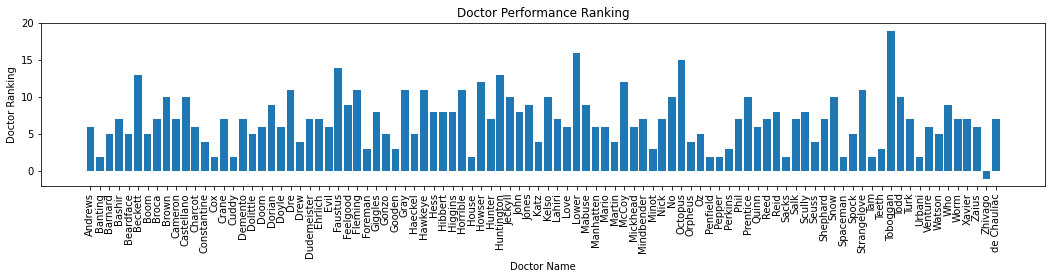

In [53]:
fig, ax=plt.subplots(figsize=(18, 3))
_=ax.bar(x=test.servicing_provider_name, height=test.evaluation)
plt.xticks(rotation=90)
plt.title('Doctor Performance Ranking')
plt.xlabel('Doctor Name')
plt.ylabel('Doctor Ranking')
plt.show();
